# Exploratory Analysis of Bay Area Bike Share Data

The initial load and cleanup step produces a new, combined dataset which is then saved. After the first run, we can skip this step and head directly to the [initial analysis](#Reload-and-Initial-Assessment)

In [30]:
# shared imports and global variables
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

bc = sb.color_palette()[0]

## Initial load and cleanup

We'll begin by loading up our datasets, which are available here: https://www.lyft.com/bikes/bay-wheels/system-data

We already notice something interesting. When the data began being collected, it was saved and labelled as `fordgobike-tripdata.csv`, preceded by what looks like year and month; ie, `201806-fordgobike-tripdata.csv.zip`. Then, beginning with the May 2019 dataset, the filename format switches to `baywheels-tripdata`. We see also that the site now carries Lyft branding. Poking around a little, we learn that Ford and Lyft have partnered on a few projects, and at some point Lyft took over Ford's bikeshare program: https://blog.lyft.com/posts/introducing-bay-wheels-new-bikes-and-a-new-name

For our purposes, this is worth noting because it might affect the format of the datasets and require some wrangling. We'll begin by loading the datasets into memory and seeing what's there. Immediately, we run into an issue: one file uses a different delimiter from all the others.

In [1]:
csvs = [ f for f in os.listdir('data') if f.endswith('.csv')]
data = {}
for c in csvs:
    try:
        if c == '201907-baywheels-tripdata.csv':
            data[ c[:c.index('-')] ] = pd.read_csv(os.path.join('data', c), sep=";")
        else:
            data[ c[:c.index('-')] ] = pd.read_csv(os.path.join('data', c))
    except:
        print ("Error loading {}".format(c))

/home/steve/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/steve/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
shared_columns = {}
for date, d in data.items():
    print('{}\n'.format(date))
    print('\tRows: {0}\tColumns: {1}\n'.format(*d.shape))
    col_set = set(d.columns)
    if not shared_columns:
        shared_columns = col_set
    else:
        if col_set > shared_columns:
            print("\tExtra columns: {}\n".format(col_set - shared_columns))
        elif col_set < shared_columns:
            print("\tMissing columns: {}\n".format(shared_columns - col_set))
print('Shared columns:\n')
for c in sorted(list(shared_columns)):
    print('\t{}'.format(c))

201905

	Rows: 182163	Columns: 16

201804

	Rows: 131169	Columns: 16

201907

	Rows: 258102	Columns: 17

	Extra columns: {'rental_access_method'}

201809

	Rows: 186217	Columns: 16

201803

	Rows: 111382	Columns: 16

201802

	Rows: 106718	Columns: 16

201909

	Rows: 217986	Columns: 16

201801

	Rows: 94802	Columns: 16

201806

	Rows: 195968	Columns: 16

201901

	Rows: 192082	Columns: 16

201906

	Rows: 191772	Columns: 17

	Extra columns: {'rental_access_method'}

201805

	Rows: 179125	Columns: 16

201904

	Rows: 239111	Columns: 16

201902

	Rows: 183412	Columns: 16

201908

	Rows: 210563	Columns: 16

201812

	Rows: 131363	Columns: 16

201810

	Rows: 201458	Columns: 16

2017

	Rows: 519700	Columns: 15

	Missing columns: {'bike_share_for_all_trip'}

201808

	Rows: 192162	Columns: 16

201807

	Rows: 199222	Columns: 16

201910

	Rows: 239895	Columns: 16

201811

	Rows: 134135	Columns: 16

201903

	Rows: 256299	Columns: 16

Shared columns:

	bike_id
	bike_share_for_all_trip
	duration_sec
	e

We see that 2 datasets (June and July 2019) have an extra column, `rental_access_method`; and the dataset for 2017 is missing a column, `bikeshare_for_all_trip`. We'll drop and fill these columns, respectively.  Here it's also worth noting a shift in data-gathering policy. While all the other datasets from 2018 and 2019 are grouped by month, there is only 1 dataset for the entirety of 2017. Accordingly, the 2017 dataset has more than twice as many rows as any other 1 dataset. We're not yet sure how much of 2017 is tracked in the dataset, but it likely spans multiple months.

After handling the noted columns, we'll merge all of the data into single, massive dataframe.

In [3]:
data['201906'] = data['201906'].drop(columns=['rental_access_method'])
data['201907'] = data['201907'].drop(columns=['rental_access_method'])

df_merged = data['2017'].copy()
df_merged['bike_share_for_all_trip'] = np.nan
for d in data:
    if d == '2017':
        continue
    df_merged = pd.concat([df_merged, data[d] ], ignore_index=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 556.0+ MB


Our combined dataset has more than 4.5 million rows, and weighs in at over 550 MB... yikes. As the analysis proceeds, we'll have to keep an eye on memory. In the meantime, we'll save the combined dataframe and reclaim memory from the individual datasets. We'll also recast the datatypes of some of the combined columns to better serve future analysis.

In [4]:
df = df_merged.copy()

In [5]:
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)
df.start_station_id = df.start_station_id.astype('Int64').astype(str)
df.end_station_id = df.end_station_id.astype('Int64').astype(str)
df.bike_id = df.bike_id.astype('Int64').astype(str)
df.member_birth_year= df.member_birth_year.astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          Int64
member_gender              object
bike_share_for_all_trip    object
dtypes: Int64(1), datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 560.4+ MB


In [6]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987,Male,NaN
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965,Female,NaN
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997,Female,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          Int64
member_gender              object
bike_share_for_all_trip    object
dtypes: Int64(1), datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 560.4+ MB


### Dataset Structure
The combined dataset has 16 columns, minus the extra "rental_access_method" column that was only available for 2 months. The data provides several points of interest: start and end locations and times, duration of trip, and rider information for gender, age, and type of user ("Customer" or "Subscriber"). Two additional columns, "bike_id" and "bike_share_for_all_trip" look less promising for any sort of insight, but no assumptions will be made (for now).

### Main Features of Interest
I think the most interesting questions here will be related to time; namely, how has bikeshare usage changed since data began being collected? Bikeshare systems are still relatively new, so we would like some insight into how usage varies as the system matures. The central question: how many rides are being taken each day, for how long, and to which destinations? And with an eye on ride data, we can ask other questions related to the riders: do rides vary with rider age, gender, or type? 

### Expectations
I expect that we will see usage increasing over time, and stabilizing across the various features of gender, age, location, and duration. 

In [8]:
del data
del df_merged

In [32]:
pd.to_pickle(df, 'data/combined_data.pkl.zip')
del df

## Reload and Initial Assessment

In [31]:
df = pd.read_pickle('data/combined_data.pkl.zip')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987,Male,NaN
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965,Female,NaN
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997,Female,NaN


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          Int64
member_gender              object
bike_share_for_all_trip    object
dtypes: Int64(1), datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 560.4+ MB


We'll begin by stepping through the individual features and seeing what's available to us.

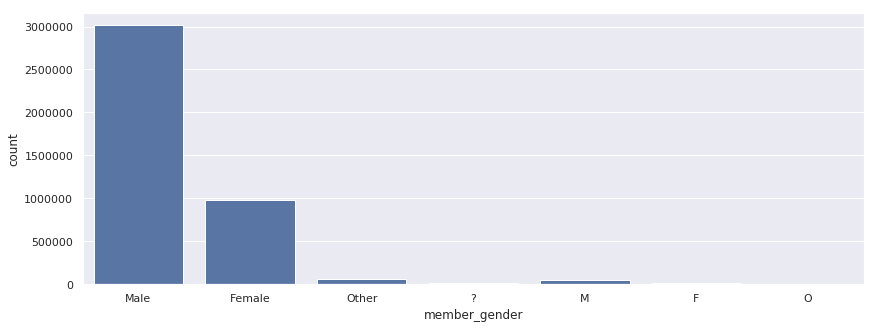

In [33]:
sb.countplot(data = df, x = 'member_gender', color = bc);

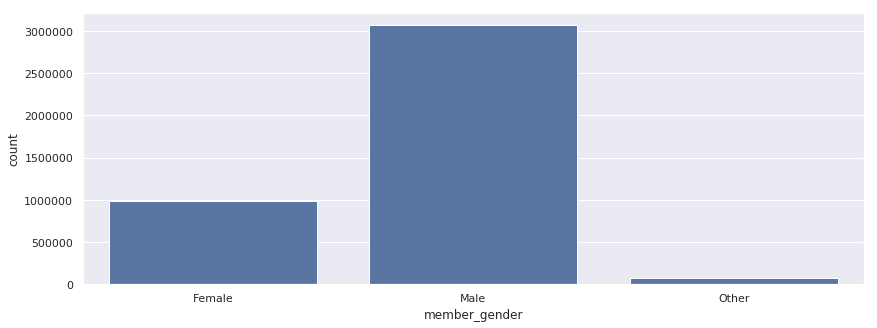

In [34]:
df.member_gender = df.member_gender.replace({'M': 'Male', 'F': 'Female', 'O': 'Other', '?': 'Other'})
df.member_gender = df.member_gender.astype('category')
sb.countplot(data = df, x = 'member_gender', color = bc);

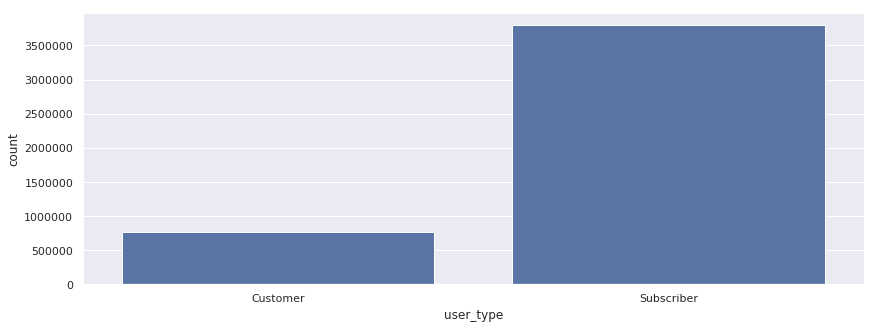

In [35]:
sb.countplot(data = df, x = 'user_type', color = bc);

In [36]:
df.user_type = df.user_type.astype('category')

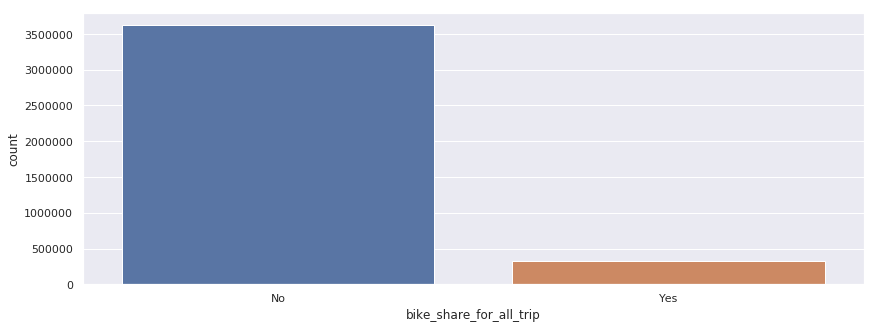

In [37]:
sb.countplot(data=df, x='bike_share_for_all_trip');

It's unclear what exactly `bike_share_for_all_trip` represents. It looks like less than 10% of the data has a value of `Yes` for the attribute. What's more, looking back at the [data definitions](https://www.lyft.com/bikes/bay-wheels/system-data), we don't even see this attribute described. Given the skew and lack of definition, this data doesn't appear to hold much value. In the interest of memory usage and performance, we'll drop this column for the rest of the analysis.

In [38]:
df.drop('bike_share_for_all_trip', axis=1, inplace=True)

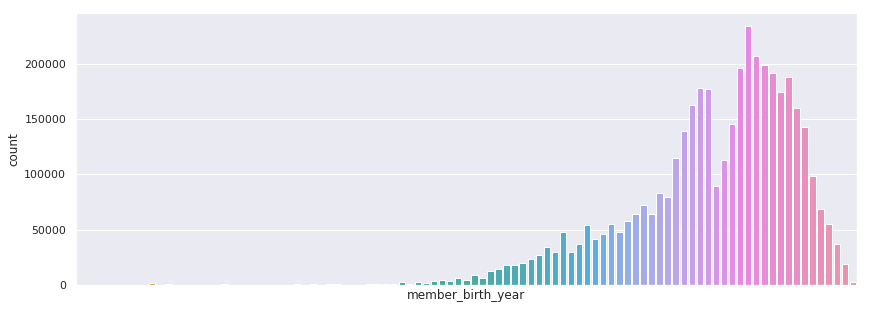

In [39]:
ax = sb.countplot(data=df, x='member_birth_year')
ax.set_xticks([]);

In [40]:
df.member_birth_year.value_counts()

1988    234172
1989    207045
1990    198413
1987    196202
1991    191347
1993    187919
1985    178209
1986    177174
1992    174312
1984    162837
1994    159728
1983    145612
1995    142341
1982    138691
1980    114812
1981    113092
1996     98390
1979     89428
1977     82651
1978     79026
1975     72385
1997     68863
1974     64018
1976     63952
1973     57509
1998     55387
1971     54781
1968     53905
1972     48189
1965     48082
         ...  
1911       285
1924       200
1920       185
1939       144
1934       120
1896       100
1938        94
1940        81
1901        80
1928        51
1890        44
1932        38
1904        30
1927        29
1889        24
1888        23
1914        18
1899        11
1878         8
1907         7
1895         7
1923         6
1881         5
1909         4
1886         3
1930         3
1906         2
1903         1
1910         1
1919         1
Name: member_birth_year, Length: 97, dtype: int64

In [41]:
df.start_station_name.value_counts()

San Francisco Ferry Building (Harry Bridges Plaza)                 88833
San Francisco Caltrain Station 2  (Townsend St at 4th St)          86248
Market St at 10th St                                               86120
Berry St at 4th St                                                 82050
San Francisco Caltrain (Townsend St at 4th St)                     80227
Montgomery St BART Station (Market St at 2nd St)                   75443
The Embarcadero at Sansome St                                      72832
Powell St BART Station (Market St at 4th St)                       72173
Steuart St at Market St                                            66103
Howard St at Beale St                                              63457
Powell St BART Station (Market St at 5th St)                       59997
Embarcadero BART Station (Beale St at Market St)                   49038
3rd St at Townsend St                                              48616
Townsend St at 7th St                              

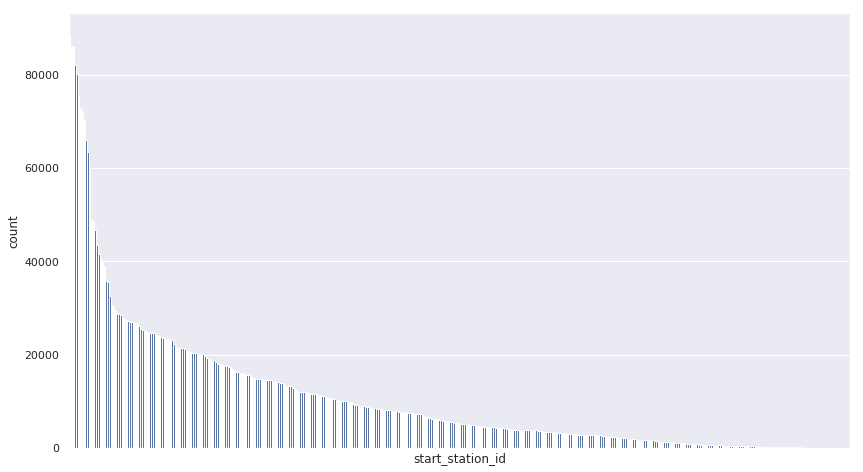

In [42]:
sb.set(rc={'figure.figsize':(14,8)})
start_ord = df['start_station_id'].value_counts().index
ax = sb.countplot(data = df, x = 'start_station_id', color = bc, order = start_ord)
ax.set_xticks([]);

In [43]:
df.end_station_name.value_counts()

San Francisco Caltrain Station 2  (Townsend St at 4th St)          115804
San Francisco Ferry Building (Harry Bridges Plaza)                 104061
San Francisco Caltrain (Townsend St at 4th St)                      99510
Montgomery St BART Station (Market St at 2nd St)                    90552
The Embarcadero at Sansome St                                       85649
Market St at 10th St                                                84307
Berry St at 4th St                                                  79853
Powell St BART Station (Market St at 4th St)                        76349
Steuart St at Market St                                             67034
Powell St BART Station (Market St at 5th St)                        62238
Howard St at Beale St                                               57081
Townsend St at 7th St                                               47605
3rd St at Townsend St                                               46424
Civic Center/UN Plaza BART Station (Ma

In [44]:
df.start_station_id.value_counts()

15     88833
67     86248
58     86120
81     82050
30     80227
21     75443
6      72832
3      72173
nan    70563
16     66103
22     63457
5      59997
17     49038
66     48616
50     46699
90     43394
44     41570
27     40507
93     39929
23     39055
182    35730
19     35550
243    32476
24     30656
61     30513
20     29450
324    28773
114    28592
28     28462
176    28054
       ...  
466      124
391      122
413      118
427       88
469       58
404       57
438       44
436       44
421       42
471       41
463       40
434       39
474       37
470       35
374       25
432       23
435       21
437       19
442       17
408        9
475        7
473        7
65         6
428        5
429        4
472        4
329        3
482        2
476        2
420        1
Name: start_station_id, Length: 427, dtype: int64

In [45]:
df.start_station_id.replace({'nan': '-1'}, inplace=True)
df.end_station_id.replace({'nan': '-1'}, inplace=True)

In [46]:
df.start_station_id.value_counts()

15     88833
67     86248
58     86120
81     82050
30     80227
21     75443
6      72832
3      72173
-1     70563
16     66103
22     63457
5      59997
17     49038
66     48616
50     46699
90     43394
44     41570
27     40507
93     39929
23     39055
182    35730
19     35550
243    32476
24     30656
61     30513
20     29450
324    28773
114    28592
28     28462
176    28054
       ...  
466      124
391      122
413      118
427       88
469       58
404       57
438       44
436       44
421       42
471       41
463       40
434       39
474       37
470       35
374       25
432       23
435       21
437       19
442       17
408        9
475        7
473        7
65         6
428        5
429        4
472        4
329        3
482        2
476        2
420        1
Name: start_station_id, Length: 427, dtype: int64

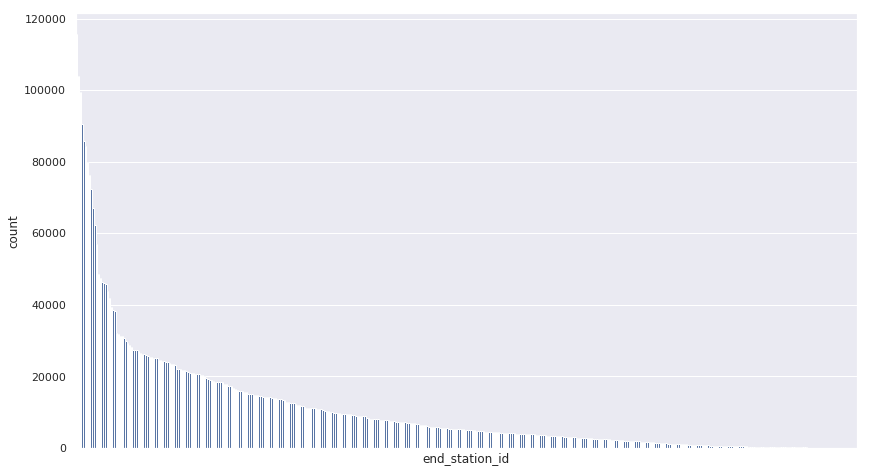

In [47]:
start_ord = df['end_station_id'].value_counts().index
ax = sb.countplot(data = df, x = 'end_station_id', color = bc, order = start_ord)
ax.set_xticks([]);

In [48]:
df.bike_id.value_counts()

2174      1967
2692      1964
1396      1927
3379      1883
1161      1882
3146      1864
2387      1843
232       1835
2497      1832
3105      1831
2545      1823
2753      1818
126       1817
746       1812
1181      1808
1543      1804
1511      1794
2941      1791
3067      1790
3381      1785
2317      1782
817       1781
1182      1780
2882      1779
277       1776
1406      1773
3670      1769
3135      1763
661       1760
2706      1758
          ... 
4169         2
252879       1
729615       1
659091       1
799849       1
655034       1
607086       1
5688         1
11768        1
657708       1
414464       1
11422        1
6304         1
6987         1
12034        1
3763         1
12501        1
582534       1
6702         1
3758         1
5777         1
552865       1
12985        1
6271         1
289022       1
10708        1
6601         1
165349       1
11123        1
3323         1
Name: bike_id, Length: 11898, dtype: int64

In [49]:
df.bike_id.nunique()

11898

Like `bike_share_for_all_trip`, the `bike_id` attribute has questionable value. Presumably, it maps an ID to a particular bike, and not a user, judging by the count of unique values. (One expects that a city of San Francisco's size would have more than 12000 unique users over 2+ years). While this data might be useful for a fine-grained analysis, it seems out of scope here. We will again drop this to preserve system resources.

In [50]:
df.drop('bike_id', axis=1, inplace=True)

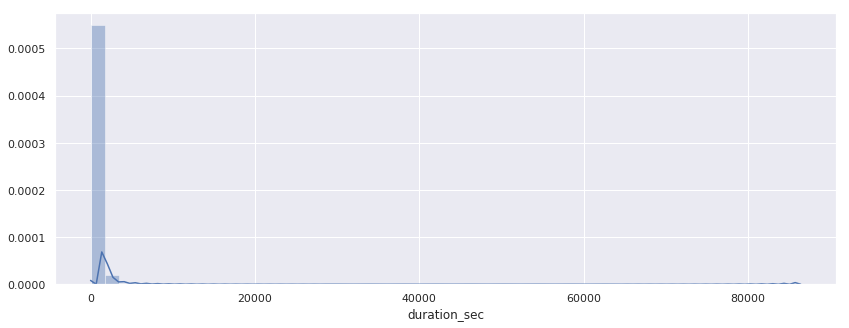

In [51]:
sb.set(rc={'figure.figsize':(14,5)})
sb.distplot(df['duration_sec']);

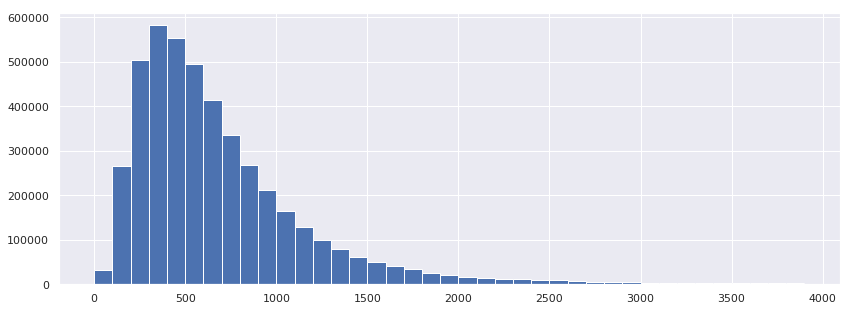

In [52]:
bins = np.arange(0, 4000, 100)
plt.hist(data=df, x='duration_sec', bins=bins);

### Enhancing the data

In [53]:
#https://gist.github.com/rochacbruno/2883505
#https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6

def distance(start_lat, start_lon, end_lat, end_lon):
    radius = 6371 * 1000 # meters
    
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [start_lat, start_lon, end_lat, end_lon])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    d = radius * c

    return np.floor(d)

In [54]:
df['trip_distance'] = distance( df.start_station_latitude, df.start_station_longitude,
    df.end_station_latitude, df.end_station_longitude)

In [55]:
df.trip_distance.describe()

count    4.554806e+06
mean     1.726826e+03
std      3.284722e+04
min      0.000000e+00
25%      8.980000e+02
50%      1.413000e+03
75%      2.159000e+03
max      1.279835e+07
Name: trip_distance, dtype: float64

In [59]:
df[ df.trip_distance > 100000]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_birth_year,member_gender,trip_distance
1059576,7890,2019-07-24 09:29:16.000,2019-07-24 11:40:47.000,-1,NaN,37.789527,-122.401979,-1,NaN,36.739538,-121.469453,Subscriber,NaN,Other,142971.0
2568363,2365,2019-04-30 18:21:42.610,2019-04-30 19:01:08.146,50,2nd St at Townsend St,37.780526,-122.390288,420,SF Test Station,0.000000,0.000000,Subscriber,1995,Female,12792805.0
2569129,1964,2019-04-30 17:31:19.646,2019-04-30 18:04:04.518,98,Valencia St at 16th St,37.765052,-122.421866,420,SF Test Station,0.000000,0.000000,Subscriber,1981,Female,12796015.0
2569283,546,2019-04-30 17:45:38.452,2019-04-30 17:54:45.258,370,Jones St at Post St,37.787327,-122.413278,420,SF Test Station,0.000000,0.000000,Subscriber,1991,Female,12794414.0
2569362,630,2019-04-30 17:39:33.507,2019-04-30 17:50:04.314,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,420,SF Test Station,0.000000,0.000000,Subscriber,1991,Male,12793300.0
2569815,433,2019-04-30 17:17:10.486,2019-04-30 17:24:23.919,11,Davis St at Jackson St,37.797280,-122.398436,420,SF Test Station,0.000000,0.000000,Subscriber,1995,Male,12792797.0
2569898,1233,2019-04-30 16:58:41.209,2019-04-30 17:19:14.689,81,Berry St at 4th St,37.775880,-122.393170,420,SF Test Station,0.000000,0.000000,Subscriber,1970,Male,12793228.0
2569930,1306,2019-04-30 16:55:35.924,2019-04-30 17:17:22.162,80,Townsend St at 5th St,37.775235,-122.397437,420,SF Test Station,0.000000,0.000000,Subscriber,1992,Male,12793604.0
2570221,764,2019-04-30 16:44:12.351,2019-04-30 16:56:56.539,16,Steuart St at Market St,37.794130,-122.394430,420,SF Test Station,0.000000,0.000000,Customer,1976,Male,12792596.0
2582472,1491,2019-04-28 18:40:41.288,2019-04-28 19:05:33.063,377,Fell St at Stanyan St,37.771917,-122.453704,420,SF Test Station,0.000000,0.000000,Customer,1981,Male,12798346.0


There are several outliers here skewing the summary statistics. The main issue is that a number of observations seem to be test data, using either `SF Test Station` or `16th Depot Bike Station` as a starting or ending point. These stations have the prime meridian as a dummy value for latitude and longitude, which is throwing our distance measure way off. There is one other observation with a distance of greater than 100,000 meters, but with no start or end station. While an outlier, [this appears to be legitimate](https://goo.gl/maps/S3rYWtfU2e23H7VP6). We'll retain that observation in recognition of such an intrepid journey, but drop the test data (while admiring the Baywheels team's dedication to the Bay Area reputation in its choice of IDs).

In [62]:
# Western Hemisphere only
df = df[ (df.start_station_longitude != 0) & (df.end_station_longitude != 0) ]
df[ df.trip_distance > 100000]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_birth_year,member_gender,trip_distance
1059576,7890,2019-07-24 09:29:16,2019-07-24 11:40:47,-1,NaN,37.789527,-122.401979,-1,NaN,36.739538,-121.469453,Subscriber,NaN,Other,142971.0


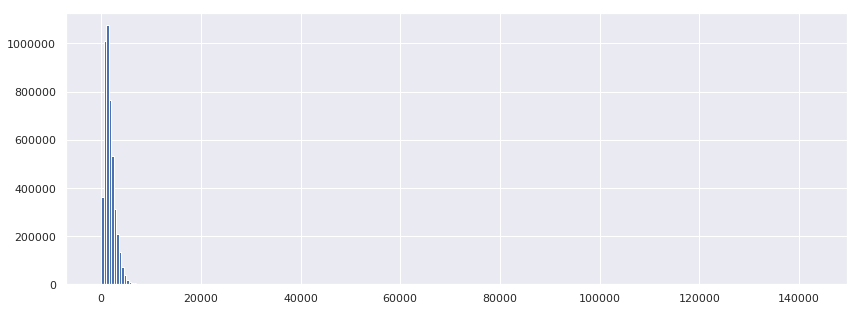

In [63]:
bins = np.arange(0, df.trip_distance.max() + 1, 500)
plt.hist(data=df, x='trip_distance', bins=bins);

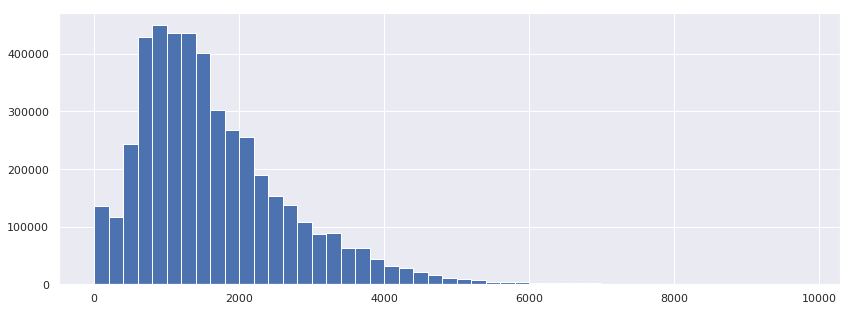

In [64]:
bins = np.arange(0, 10000, 200)
plt.hist(data=df, x='trip_distance', bins=bins);

In [65]:
df[ df.start_time.dt.year < 2018 ]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_birth_year,member_gender,trip_distance
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,Customer,1987,Male,942.0
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,Customer,1965,Female,3069.0
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,Customer,NaN,NaN,0.0
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,Customer,NaN,NaN,1046.0
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,Subscriber,1997,Female,636.0
5,9226,2017-12-31 22:51:00.918,2018-01-01 01:24:47.166,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,Customer,NaN,NaN,0.0
6,4507,2017-12-31 23:49:28.422,2018-01-01 01:04:35.619,259,Addison St at Fourth St,37.866249,-122.299371,259,Addison St at Fourth St,37.866249,-122.299371,Customer,1991,Female,0.0
7,4334,2017-12-31 23:46:37.196,2018-01-01 00:58:51.211,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,Customer,NaN,NaN,0.0
8,4150,2017-12-31 23:37:07.548,2018-01-01 00:46:18.308,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,Customer,NaN,NaN,0.0
9,4238,2017-12-31 23:35:38.145,2018-01-01 00:46:17.053,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,Customer,NaN,NaN,0.0


In [66]:
df[ df.start_time.dt.year < 2018 ].start_time.dt.month.value_counts()

10    108937
9      98558
11     95612
12     86539
8      83292
7      44073
6       2689
Name: start_time, dtype: int64

In [67]:
df['ride_date'] = df.start_time.dt.floor('d')
df['duration_min'] = df.duration_sec // 60
df['member_age'] = df.start_time.dt.year - df.member_birth_year

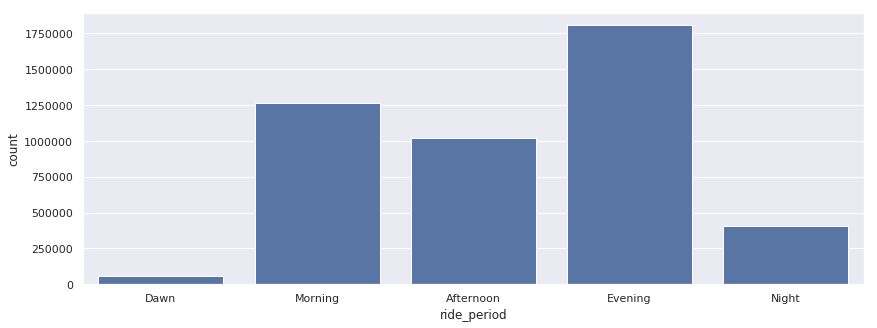

In [68]:
df['ride_period'] = pd.cut(df.start_time.dt.hour,
                           bins=[-1,4,9,14,19,24],
                           labels=['Dawn','Morning','Afternoon','Evening','Night'] )
sb.countplot(data = df, x = 'ride_period', color = bc);

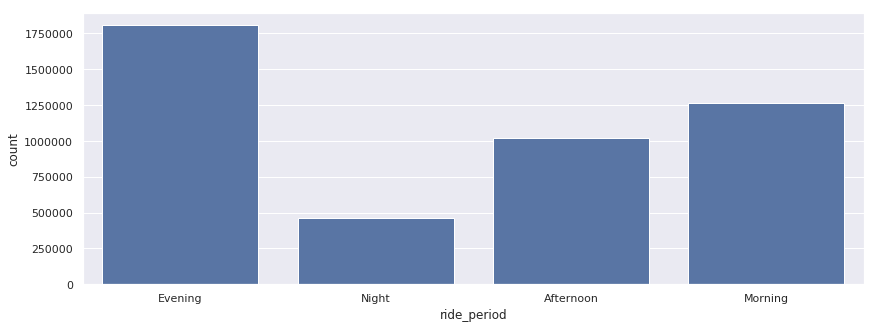

In [69]:
df['ride_period'] = df.ride_period.replace({'Dawn': 'Night'})
sb.countplot(data = df, x = 'ride_period', color = bc);

In [70]:
df.ride_period = df.ride_period.astype('category')
df.ride_period.cat.remove_unused_categories(inplace=True)
df.ride_period

0            Evening
1            Evening
2              Night
3            Evening
4          Afternoon
5              Night
6              Night
7              Night
8              Night
9              Night
10             Night
11             Night
12             Night
13             Night
14             Night
15             Night
16             Night
17             Night
18             Night
19             Night
20             Night
21             Night
22             Night
23             Night
24             Night
25             Night
26             Night
27             Night
28             Night
29             Night
             ...    
4554776        Night
4554777        Night
4554778        Night
4554779        Night
4554780        Night
4554781        Night
4554782        Night
4554783        Night
4554784        Night
4554785        Night
4554786        Night
4554787        Night
4554788        Night
4554789        Night
4554790        Night
4554791        Night
4554792      

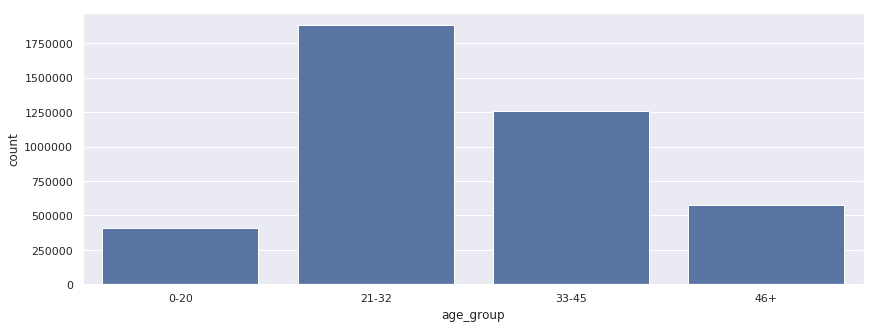

In [71]:
df['age_group'] = pd.cut(df.member_age,
                           bins=[0,20,32,45,10000],
                           labels=['0-20','21-32','33-45','46+'] )
sb.countplot(data=df, x='age_group', color=bc);

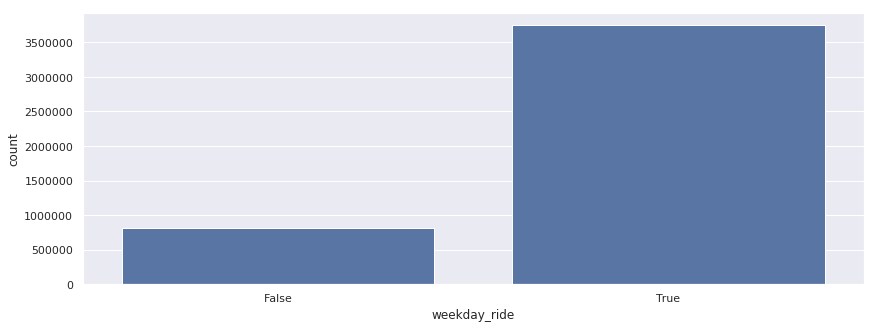

In [72]:
df['weekday_ride'] = df.ride_date.dt.dayofweek < 5
sb.countplot(data=df, x='weekday_ride', color=bc);

In [73]:
df.drop(['duration_sec', 'start_time','end_time','member_birth_year'], axis=1, inplace=True)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4554776 entries, 0 to 4554805
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 477.8+ MB


In [76]:
df_2017 = df[ df.ride_date.dt.year == 2017 ]
df_2017.head()

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_gender,trip_distance,ride_date,duration_min,member_age,ride_period,age_group,weekday_ride
0,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,Customer,Male,942.0,2017-12-31,1335,30,Evening,21-32,False
1,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,Customer,Female,3069.0,2017-12-31,1313,52,Evening,46+,False
2,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,Customer,NaN,0.0,2017-12-31,762,NaN,Night,NaN,False
3,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,Customer,NaN,1046.0,2017-12-31,1036,NaN,Evening,NaN,False
4,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,Subscriber,Female,636.0,2017-12-31,726,20,Afternoon,0-20,False


In [77]:
df_2018 = df[ df.ride_date.dt.year == 2018 ]
df_2018.head()

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_gender,trip_distance,ride_date,duration_min,member_age,ride_period,age_group,weekday_ride
701863,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,Customer,NaN,0.0,2018-04-30,1206,NaN,Night,NaN,True
701864,122,19th St at Mission St,37.760299,-122.418892,42,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,Customer,NaN,2041.0,2018-04-30,1350,NaN,Evening,NaN,True
701865,41,Golden Gate Ave at Polk St,37.781270,-122.418740,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,Subscriber,Male,2104.0,2018-04-30,1435,44,Evening,0-20,True
701866,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,115,Jackson Playground,37.765026,-122.398773,Customer,Female,2214.0,2018-04-30,1147,44,Evening,21-32,True
701867,196,Grand Ave at Perkins St,37.808894,-122.256460,233,12th St at 4th Ave,37.795812,-122.255555,Customer,Male,1456.0,2018-04-30,984,53,Evening,46+,True


In [78]:
df_2019 = df[ df.ride_date.dt.year == 2019 ]
df_2019.head()

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_gender,trip_distance,ride_date,duration_min,member_age,ride_period,age_group,weekday_ride
519700,321,5th St at Folsom,37.780146,-122.403071,60,8th St at Ringold St,37.774520,-122.409449,Customer,Female,839.0,2019-05-31,814,29,Night,21-32,True
519701,246,Berkeley Civic Center,37.869060,-122.270556,266,Parker St at Fulton St,37.862464,-122.264791,Subscriber,Male,891.0,2019-05-31,784,25,Evening,21-32,True
519702,149,Emeryville Town Hall,37.831275,-122.285633,149,Emeryville Town Hall,37.831275,-122.285633,Customer,Male,0.0,2019-05-31,98,31,Night,21-32,True
519703,186,Lakeside Dr at 14th St,37.801319,-122.262642,186,Lakeside Dr at 14th St,37.801319,-122.262642,Customer,Male,0.0,2019-05-31,43,21,Night,21-32,True
519704,34,Father Alfred E Boeddeker Park,37.783988,-122.412408,368,Myrtle St at Polk St,37.785434,-122.419622,Subscriber,Male,654.0,2019-05-31,70,52,Night,46+,True


In [79]:
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519700 entries, 0 to 519699
Data columns (total 17 columns):
start_station_id           519700 non-null object
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null object
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
user_type                  519700 non-null category
member_gender              453238 non-null category
trip_distance              519700 non-null float64
ride_date                  519700 non-null datetime64[ns]
duration_min               519700 non-null int64
member_age                 453159 non-null Int64
ride_period                519700 non-null category
age_group                  453159 non-null category
weekday_ride               519700 non-null bool
dtypes: Int64(1), bool

In [80]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863721 entries, 701863 to 4298506
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 195.5+ MB


In [81]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2171355 entries, 519700 to 4554805
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 227.8+ MB


In [83]:
pd.to_pickle(df_2017, 'data/enhanced_data_2017.pkl.zip')

In [84]:
pd.to_pickle(df_2018, 'data/enhanced_data_2018.pkl.zip')

In [85]:
pd.to_pickle(df_2019, 'data/enhanced_data_2019.pkl.zip')

In [88]:
del df
del df_2017
del df_2018
del df_2019

## Time Series Analysis

In [106]:
df_2017 = pd.read_pickle('data/enhanced_data_2017.pkl.zip')
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519700 entries, 0 to 519699
Data columns (total 17 columns):
start_station_id           519700 non-null object
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null object
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
user_type                  519700 non-null category
member_gender              453238 non-null category
trip_distance              519700 non-null float64
ride_date                  519700 non-null datetime64[ns]
duration_min               519700 non-null int64
member_age                 453159 non-null Int64
ride_period                519700 non-null category
age_group                  453159 non-null category
weekday_ride               519700 non-null bool
dtypes: Int64(1), bool

In [107]:
df_2018 = pd.read_pickle('data/enhanced_data_2018.pkl.zip')
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863721 entries, 701863 to 4298506
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 195.5+ MB


In [108]:
df_2019 = pd.read_pickle('data/enhanced_data_2019.pkl.zip')
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2171355 entries, 519700 to 4554805
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 227.8+ MB


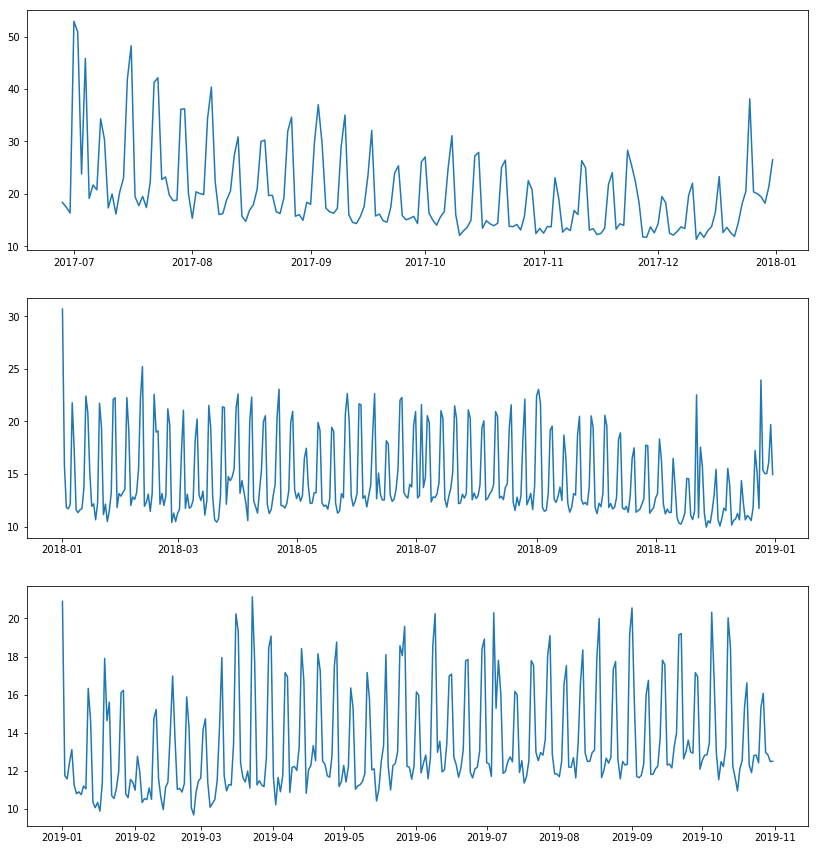

In [109]:
fig, axes = plt.subplots(3, 1, figsize=(14,15))
axes[0].plot(df_2017.groupby('ride_date')['duration_min'].mean())
axes[1].plot(df_2018.groupby('ride_date')['duration_min'].mean())
axes[2].plot(df_2019.groupby('ride_date')['duration_min'].mean())

In [ ]:
df_2017['ride_week'] = df_2017.ride_date.dt.week
df_2018['ride_week'] = df_2018.ride_date.dt.week
df_2019['ride_week'] = df_2019.ride_date.dt.week

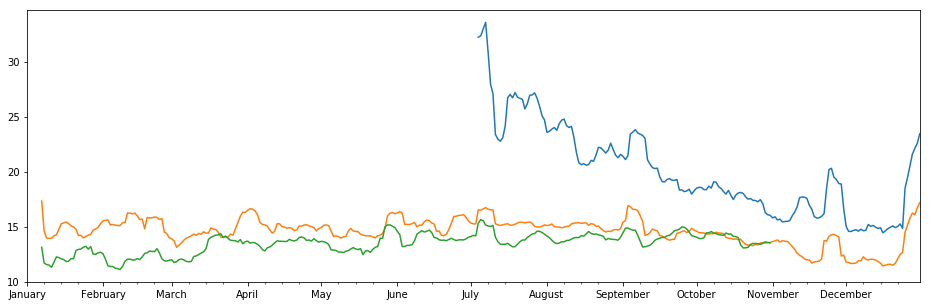

In [135]:
fig, ax = plt.subplots(figsize=(16,5))
days = mdates.DayLocator(bymonthday=[8,15,22])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%B')

ax.set_xlim(1, 365)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
ax.plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean())
ax.plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean())
ax.plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean());

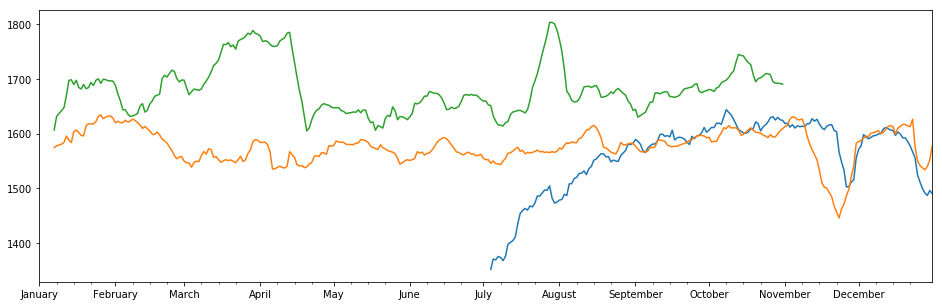

In [136]:
fig, ax = plt.subplots(figsize=(16,5))
days = mdates.DayLocator(bymonthday=[8,15,22])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%B')

ax.set_xlim(1, 365)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
ax.plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean())
ax.plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean())
ax.plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean());

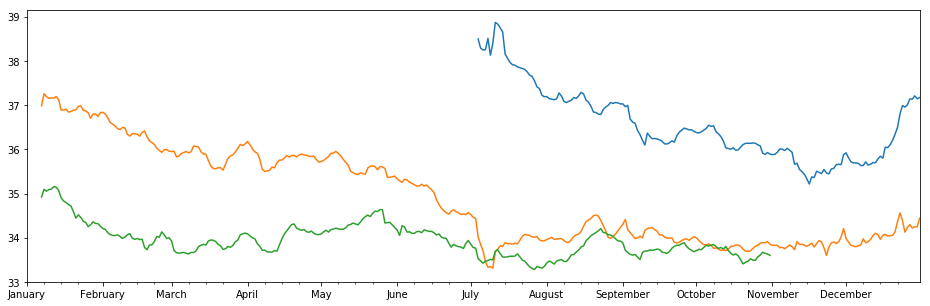

In [137]:
fig, ax = plt.subplots(figsize=(16,5))
days = mdates.DayLocator(bymonthday=[8,15,22])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%B')

ax.set_xlim(1, 365)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
ax.plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean())
ax.plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean())
ax.plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean());

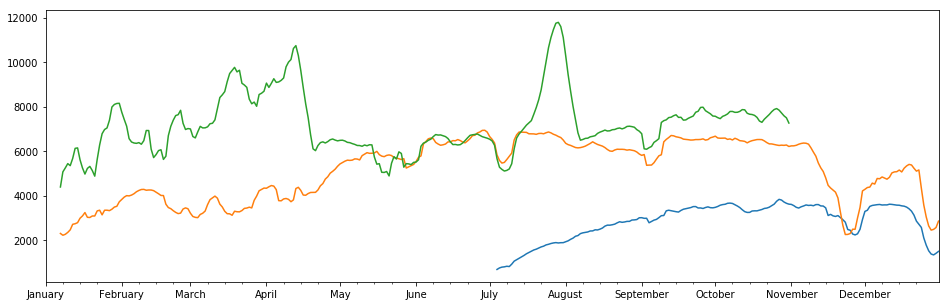

In [148]:
fig, ax = plt.subplots(figsize=(16,5))
days = mdates.DayLocator(bymonthday=[8,15,22])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%B')

ax.set_xlim(1, 365)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
ax.plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean())
ax.plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean())
ax.plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

# Scratch

In [32]:
#df.groupby('start_station_id')['start_station_longitude'].nunique()

start_station_id
10         2
100        1
101        4
102        1
104        2
105        1
106        1
107        1
108        2
109        1
11         1
110        1
112        1
113        1
114        1
115        1
116        1
118        1
119        1
12         1
120        1
121        1
122        1
123        1
124        1
125        1
126        1
127        1
129        1
13         1
       ...  
70         2
71         1
72         1
73         1
74         2
75         2
76         2
77         1
78         1
79         1
8          1
80         3
81         1
84         1
85         1
86         1
87         1
88         1
89         2
9          2
90         1
91         2
92         2
93         1
95         1
96         1
97         1
98         1
99         1
nan    55618
Name: start_station_longitude, Length: 427, dtype: int64

start_df = pd.DataFrame({'station_id': df.start_station_id, 
                         'latitude': df.start_station_latitude, 'longitude': df.start_station_longitude})
end_df = pd.DataFrame({'station_id': df.end_station_id, 
                         'latitude': df.end_station_latitude, 'longitude': df.end_station_longitude})
station_df = pd.concat([start_df, end_df])
station_df.duplicated()
station_df.drop_duplicates(inplace=True)
station_df = station_df[ station_df.station_id != '0']
station_df.nunique()

station_df.station_id.value_counts()

In [30]:
def agg_data(group):
    return {'count': group.count(),
            'num_male': group.filter(lambda x: x['member_gender'] == 'Male').count(),
            'num_female': group.filter(lambda x: x['member_gender'] == 'Female').count(),
            'avg_age': group.member_age.avg(),
            'avg_duration': group.duration_min.avg(),
            'avg_distance': group.trip_distance.avg() }

In [31]:
#date_df = enf.groupby(['start_year','start_month','start_day']).apply(agg_data).unstack
#date_df

TypeError: 'function' object is not iterable